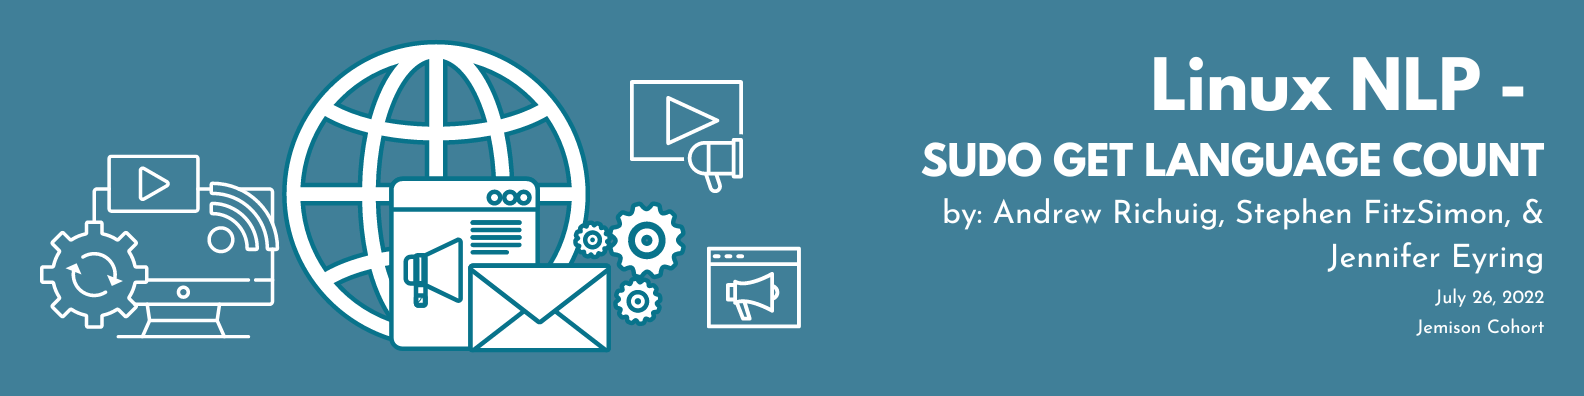

## PREDICTING PROGRAMMING LANGUAGE WITHIN LINUX README REPOS

by Andrew Rachuig, Stephen Fitzsimon and Jennifer Eyring

_______________________________

<b>Introduction Notes:</b> This NLP project is based on utilizing webscraping methods to create a predictive Logistical Regression Model.
<br>
<br>
Our team scraped the top 3,300 most-forked Linux Github repositories (as of July 20, 2022) to determine what are the top programming languages being used on Github projects.
<br>
<br>
After finding the top languages being used for each Github repo, we then took the words/wording within the README sections of the repos to see if we could build a model that could predict what programming language was used; solely based on the README content and text.
<br>
<br>
### <b>Audience Notes about the Data:</b> 
The source of our data came from webscraping the top-forked Linux Github repositiories, by searching Linux and then also pulling the content of Linux's three common flavors: Arch, Debian and Ubuntu. You can read more of the step-by-step of how to replicate this repo in the README section.


__________________

## Initial Questions when starting this project:

Our initial questions and hypotheses were applied to the full corpus of all the Linux repos, as well as also thinking on micro-levels on what questions we could ask between the 3 flavors of Linux that was webscraped as well.

#### Full Corpus:
> - How many & what are the unique words to each specific programming language?<br><br>
> - Are there any bigrams/trigrams that are specific to certain programming languages?<br><br>
> - Do certain programming languages have larger README sections than others? And if so, which ones?<br><br>
#### Flavors of Linux (ie Archlinux, Debian and Ubuntu:
> - With Linux-flavors-Debian, Arch and Ubuntu-are there differences in README lengths? (ie does one flavor over the others seem to have more details needed or explained than others?)<br><br>
> - Are there differences in words/phrases to Linux-flavors- specifically Ubuntu, Debian and Archlinux.<br><br>

__________________________

# Project Goals:

> - Utilize Codeup's webscraping function and apply it to our project's parameters of obtaining the top-forked Linux repositories.<br><br>
> - To determine any commonalities/differences between programming languages and the README sections of the repositories.<br><br>
> - Create a classification model that can predict what programming language is used, solely based on the README content/words.

# Executive Summary:

___________________________________________

<h1>ABOUT THE DATA:</h1>

Our team collected 3,300 top-forked Github repos that were specific flavors of Linux: Archlinux, Ubuntu, and Debian repositiores. Each flavor we pulled 1,100 and then combined these webscraped repositories into one large dataframe.

### Key notes:
- 3,300 repositories were collected.
- 2,805 were used in this model, after clean/normalizing data.
- <b>Top 3 programming languages used in all the repos:
    - 1) Shell
    - 2) Python
    - 3) C


<div class="alert alert-info">
Size of data:<br>
<b>Pre-Clean/Normalize: 3,300 rows | 3 columns

<b>After cleaning & normalizing: 2,805 rows | 6 columns
</div>

## Wrangle Process:

#### Measures taken to clean and normalize the data:

> 1) We dropped all nulls as these related to repos that had no languages defined.<br><br>
> 2) Using NLTK tools, we replaced any abnormal symbols and https-related phrases with single spaces on the readme_contents column.<br><br>
> 3) We tokenized the dataset on this same column.<br><br>
> 4) After cleaning/normalizing, we had used the proportions of most common words throughout the repos across every programming language to determine which words need to be removed as they took away from the information the corpus was provided on predictability.<br><br>
> 5) We lowered all capitilizations within the readme content.<br><br>
> 6) And finally we stemmed all words so keep key words/phrases similar.<br><br>
> 7) We added the following columns:
- `disto` : to label which repos were Arch, Ubuntu or Debian
- `clean_readme` : to have a comparison of the original collected text `readme_contents`
- `length_readme`: counts how many unique words are in each repo.
- `readme_string`: that takes the clean_readme and applies as strings rather than list.

______________________

## Exploring the main dataset:

#### Calling in the data:

In [73]:
#imports:

#tools for web scraping:
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd
import numpy as np

#group imports
import env
import acquire
import constants_prepare as c

import json
from typing import Dict, List, Optional, Union, cast
import requests
import nltk

#visualizations:
import matplotlib.pyplot as plt
import seaborn as sns

#hypothesis testing
import scipy.stats as stats

#modeling tools
from sklearn.metrics import classification_report, accuracy_score
import modeling as m

#ignore minor warnings
import warnings
warnings.filterwarnings("ignore")


In [11]:
#calling in master_df:
master_df = pd.read_csv('master_list.csv')

#handling nulls of rows that do not have languages mentioned:
master_df = c.drop_nulls(master_df)

#importing our clean/normalization function
master_df = c.adding_columns(master_df)
master_df.head()

,repo,language,readme_contents,distro,clean_readme,length_of_readme,readme_string
0,dockerfile/ubuntu,Shell,## Ubuntu Dockerfile\n\n\nThis repository cont...,ubuntu,"[ubuntu, dockerfil, repositori, contain, docke...",31,"ubuntu,dockerfil,repositori,contain,dockerfil,..."
1,boxcutter/ubuntu,Shell,# Packer templates for Ubuntu written in legac...,ubuntu,"[packer, templat, ubuntu, written, legaci, jso...",501,"packer,templat,ubuntu,written,legaci,json,over..."
2,wszqkzqk/deepin-wine-ubuntu,C,# Deepin wine for Ubuntu and Debian\n\n## 一、项目...,ubuntu,"[deepin, wine, ubuntu, debian, deepinwin, ubun...",164,"deepin,wine,ubuntu,debian,deepinwin,ubuntudebi..."
3,fcwu/docker-ubuntu-vnc-desktop,HTML,# docker-ubuntu-vnc-desktop\n\n[![Docker Pulls...,ubuntu,"[dockerubuntuvncdesktop, docker, pull, docker,...",386,"dockerubuntuvncdesktop,docker,pull,docker,star..."
4,docker-32bit/ubuntu,Shell,ubuntu\n======\n\nBuild a docker image for ubu...,ubuntu,"[ubuntu, build, docker, imag, ubuntu, i386, ru...",14,"ubuntu,build,docker,imag,ubuntu,i386,run,build..."


### TOP 10 COMMON LANGUAGES USED IN FULL CORPUS:

In [4]:
master_language_count=pd.concat([master_df.language.value_counts(), master_df.language.value_counts(normalize=True)], axis = 1). head(10)
master_language_count

,language,language
Shell,1598,0.569697
Python,289,0.103030
C,141,0.050267
Dockerfile,99,0.035294
C++,63,0.022460
HTML,59,0.021034
JavaScript,53,0.018895
Makefile,52,0.018538
CSS,48,0.017112
Ruby,48,0.017112


In [5]:
m_count = master_df.language.value_counts(normalize=True).head(10)

In [6]:
#creating a df of the percentages to prep for charts:
temp = pd.DataFrame({'language' : m_count.index, 'percentage': m_count.values})

Text(0.5, 1.0, 'Percentages of the Top 10 Linux Repo languages')

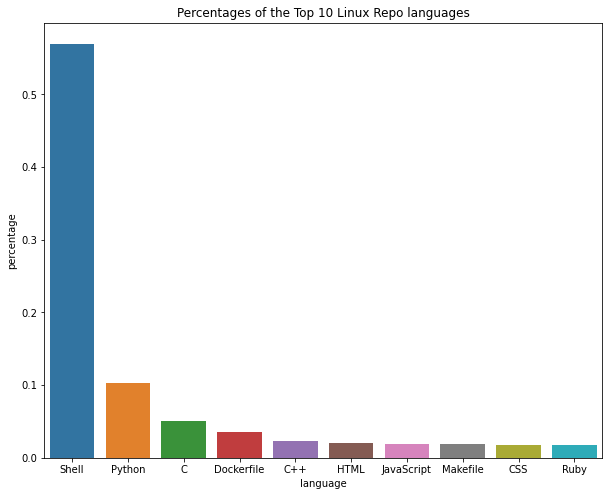

In [7]:
#plotting out the percentages of the Top 10 languages used in Ubuntu repos:
plt.figure(figsize=(10,8))
sns.barplot(data=temp, x = 'language', y = 'percentage')
plt.title('Percentages of the Top 10 Linux Repo languages')

### Average length of Repositories:
#### Key takeaways:
- Our initial question of : <i>Do certain programming languages have larger README sections than others? And if so, which ones?</i> is answered here.
    - Surprisingly the length of respositories based on language count does not reflect the most common languages used. 
    - It does make sense that Jupyter Notebook would have the longest README length, as these were pulled from Github.
    - However, it is surprising to see that none of the top most used languages are not even within the top 3 for average repo length.

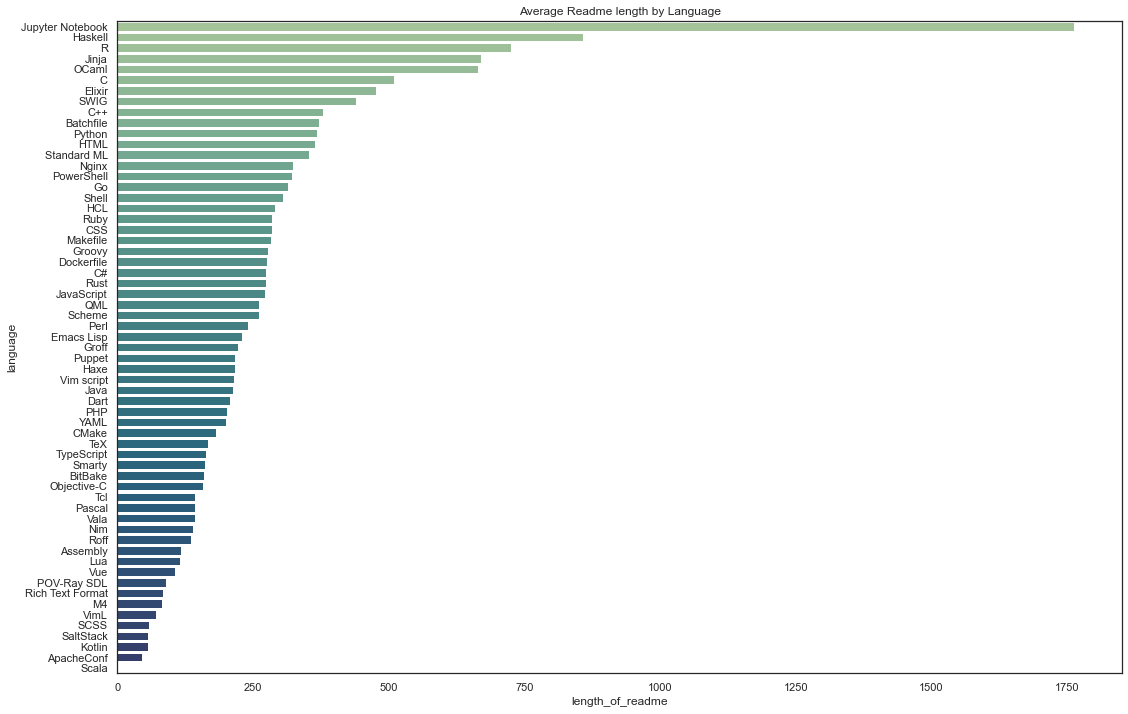

In [76]:
plt.figure(figsize=(18, 12))
sns.barplot(data = master_df.groupby('language').mean().reset_index().sort_values('length_of_readme', ascending=False), x = 'length_of_readme', y='language', palette="crest")
plt.title('Average Readme length by Language')
plt.show()

_____________________________________

## Number of Unique Words in Corpus:

In [8]:
#finding the count of unique words in the full Corpus:
linux_corpus_series = pd.Series(master_df.readme_string)
pd.Series(linux_corpus_series).nunique()

2427

In [9]:
linux_corpus_series

0       ubuntu,dockerfil,repositori,contain,dockerfil,...
1       packer,templat,ubuntu,written,legaci,json,over...
2       deepin,wine,ubuntu,debian,deepinwin,ubuntudebi...
3       dockerubuntuvncdesktop,docker,pull,docker,star...
4       ubuntu,build,docker,imag,ubuntu,i386,run,build...
                              ...                        
3293    need,use,rapidli,expand,linux,world,mani,linux...
3294    archclassroomgithubio,arch,linux,classroom,websit
3295    homerouteran,ansibl,script,set,linux,router,sh...
3296                 tial,twitch,instal,arch,linux,script
3299    pacadd,simpl,tool,manag,repositori,arch,linux,...
Name: readme_string, Length: 2805, dtype: object

In [10]:
#creating a list to find unique word counts:
linux_corpus = ' '.join(master_df['readme_string'])
linux_corpus[:100]

'ubuntu,dockerfil,repositori,contain,dockerfil,ubuntu,base,docker,imag,ubuntu1404,instal,1,instal,doc'

### Top Words & Bigrams found in Shell:

In [11]:
shell_words = master_df[master_df.language == 'Shell'].clean_readme
shell_freq = pd.Series(shell_words.str.split()).value_counts()

In [12]:
shell_list = pd.Series((i[0] for i in shell_words))
shell_list.value_counts().nlargest(10)

arch        95
ubuntu      65
debian      50
applic      32
dotfil      27
instal      26
script      22
p           20
build       20
pkgbuild    18
dtype: int64

In [13]:
#taking a look at Shell words:
shell_list.describe()

count     1598
unique     861
top       arch
freq        95
dtype: object

#### Top Bigrams found in Shell:

In [14]:
#top bigrams of Shell language in Linux repos:
top_20_shell_bigrams = (pd.Series(nltk.ngrams(shell_list, 2))
                      .value_counts()
                      .head(20))

In [15]:
top_20_shell_bigrams

(arch, arch)              15
(dotfil, arch)            10
(debian, debian)           7
(applic, applic)           6
(ubuntu, ubuntu)           6
(arch, pkgbuild)           5
(script, applic)           4
(alignc, arch)             4
(p, ubuntu)                4
(arch, link)               4
(arch, applic)             4
(pkgbuild, dotfil)         3
(packer, ubuntu)           3
(ubuntu, packer)           3
(ubuntu, termuxubuntu)     3
(arch, linux)              3
(archbootstrap, luke)      2
(arch, vdr4arch)           2
(arch, archfi)             2
(archtitu, arch)           2
dtype: int64

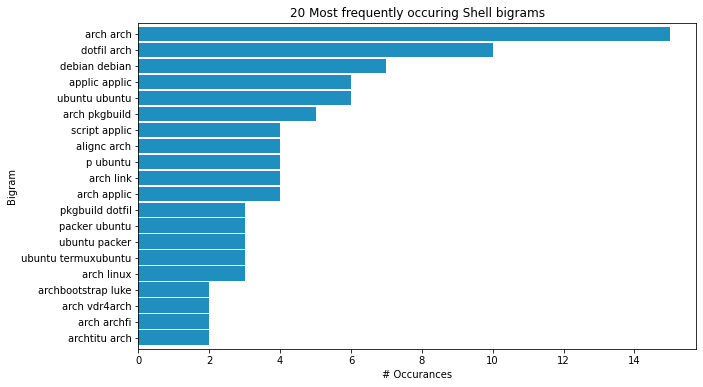

In [16]:
top_20_shell_bigrams.sort_values().plot.barh(color='#1E8FBF', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Shell bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_shell_bigrams.reset_index().sort_index(ascending=False)['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


### Top Words & Bigrams found in Python:

In [17]:
master_df.tail()

,repo,language,readme_contents,distro,clean_readme,length_of_readme,readme_string
3293,thatch45/varch,Python,==Why Do We Need Varch?==\nThe use of virtuali...,arch,"[need, use, rapidli, expand, linux, world, man...",365,"need,use,rapidli,expand,linux,world,mani,linux..."
3294,archclassroom/archclassroom.github.io,HTML,# archclassroom.github.io\nArch Linux Classroo...,arch,"[archclassroomgithubio, arch, linux, classroom...",5,"archclassroomgithubio,arch,linux,classroom,websit"
3295,gmas/home-router-ansible,Ruby,# home-router-ansible\nAnsible scripts for set...,arch,"[homerouteran, ansibl, script, set, linux, rou...",18,"homerouteran,ansibl,script,set,linux,router,sh..."
3296,Voltasalt/tial,Shell,# tial\nTwitch Installs Arch Linux: Scripts\n,arch,"[tial, twitch, instal, arch, linux, script]",6,"tial,twitch,instal,arch,linux,script"
3299,BiteDasher/pacadd,Shell,# pacadd\nA simple tool for managing repositor...,arch,"[pacadd, simpl, tool, manag, repositori, arch,...",221,"pacadd,simpl,tool,manag,repositori,arch,linux,..."


In [18]:
python_words = master_df[master_df.language == 'Python'].clean_readme
python_freq = pd.Series(python_words.str.split()).value_counts()

In [19]:
#looking at where index starts?
python_words

15      [ubuntu, tweak, introduct, ubuntu, tweak, tool...
51      [consoleconf, ubuntu, server, instal, snappi, ...
70      [ubuntu, postinst, script, python, script, avo...
79      [openstack, ubuntu, 1210, ubuntu, 1210ubuntu, ...
81      [formerli, known, ucustom, advanc, live, cd, c...
                              ...                        
3203    [helper, script, creat, arch, linux, iso, supp...
3209    [pynej, multi, arch, python, frontend, focu, l...
3257    [simpl, declar, packag, manag, arch, linux, li...
3262    [need, equiti, otherwi, sellbuy, gener, reduce...
3293    [need, use, rapidli, expand, linux, world, man...
Name: clean_readme, Length: 289, dtype: object

In [20]:
python_list = pd.Series((i[0] for i in python_words))
python_list.value_counts().nlargest(10)

IndexError: list index out of range

### Top Words and Bigrams found in C:

In [ ]:
#taking all 'C' lanugage repos from the clean_readme 
C_words = master_df[master_df.language == 'C'].clean_readme
#finding the frequency of C words/grams
C_freq = pd.Series(C_words.str.split()).value_counts()

In [ ]:
#creating a series for just unique C_words
C_list = pd.Series((i[0] for i in C_words))
C_list.value_counts().nlargest(10)

In [ ]:
#taking a look at C_words
C_list.describe()

#### Looking at Top 20 Bigrams of C language in repos:

In [ ]:
#top bigrams of C language in Linux repos:
top_20_c_bigrams = (pd.Series(nltk.ngrams(C_list, 2))
                      .value_counts()
                      .head(20))

In [ ]:
top_20_c_bigrams

In [ ]:
top_20_c_bigrams.sort_values().plot.barh(color='#143995', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring C bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_c_bigrams.reset_index().sort_index(ascending=False)['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


### Overall Takeaways:

_______________________________________

## Finding word frequencies per language:

In [ ]:
shell_words

In [ ]:
#combining frequencies into dataframes:
word_counts = (pd.concat([shell_freq, python_freq,C_freq], axis=1, sort=True)
              .set_axis(['shell','python','C'], axis=1, inplace=False)
              .fillna(0)
              .apply(lambda s: s.astype(int)))

In [ ]:
word_counts

____________________________________________________

## Exploring data by Linux Flavors:

### A snapshot of Archlinux

In [25]:
#calling in df
arch_df = pd.read_json('arch_linux_data.json')
#adding on cleaned/normalized data column:
arch_df['cleaned_readme'] = arch_df.readme_contents.apply(c.clean_data)
#adding on cleaned repo length
arch_df['cleaned_length'] = 0
for i in range(len(arch_df.cleaned_readme)):
    arch_df['cleaned_length'][i] = len(arch_df.cleaned_readme[i])
arch_df.head()

/var/folders/d3/11nygz6126ndxvtrp12687680000gn/T/ipykernel_17310/669234018.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arch_df['cleaned_length'][i] = len(arch_df.cleaned_readme[i])


,repo,language,readme_contents,cleaned_readme,cleaned_length
0,ChrisTitusTech/ArchTitus,Shell,# ArchTitus Installer Script\n[![GitHub Super-...,"[archtitu, instal, script, github, superlint, ...",243
1,archlinuxcn/repo,Shell,Arch Linux Chinese Community Repository\n====\...,"[arch, linux, chine, commun, repositori, packa...",72
2,MatMoul/archfi,Shell,# archfi\n\nJust a simple bash script wizard t...,"[archfi, simpl, bash, script, wizard, instal, ...",109
3,archlinux/archinstall,Python,"<!-- <div align=""center""> -->\n<img src=""https...","[div, alignc, img, src, div, arch, instal, pyt...",588
4,picodotdev/alis,Shell,# alis\n\n![Arch Linux](https://raw.githubuser...,"[ali, arch, linux, bash, arch, linux, instal, ...",962


In [48]:
arch_df = arch_df.dropna()

### Exploring overall data:

In [49]:
arch_df.cleaned_length.describe()

count     984.000000
mean      238.911585
std       431.256289
min         0.000000
25%        34.000000
50%       110.500000
75%       258.000000
max      7042.000000
Name: cleaned_length, dtype: float64

### The most common languages for readme files in Archlinux:

Text(0.5, 0, 'Count of Occurances')

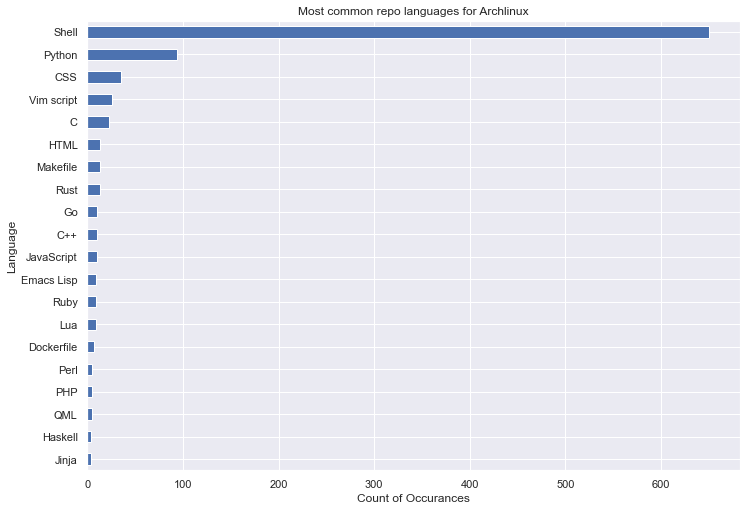

In [50]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
arch_df.language.value_counts().head(20).sort_values().plot.barh()
plt.title('Most common repo languages for Archlinux')
plt.ylabel('Language')
plt.xlabel('Count of Occurances')

In [52]:
arch_corpus_list = []
language = []
for entry in range(len(arch_df.readme_contents)):
    language.append(arch_df.language[entry])
    arch_corpus_list.extend(c.clean_data(arch_df.readme_contents[entry]))
arch_corpus = pd.Series(arch_corpus_list)
arch_corpus.describe()

KeyError: 9

<AxesSubplot:>

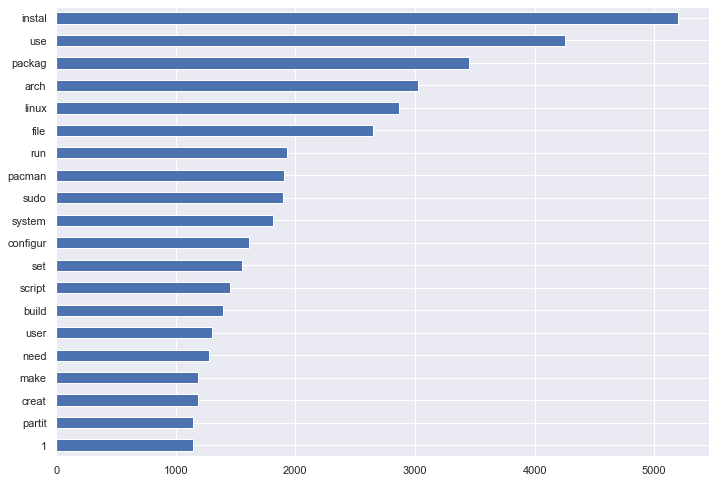

In [53]:
arch_corpus.value_counts().head(20).sort_values().plot.barh()

### Exploring and Visualizing the most bigrams of Archlinux cleaned README files:

In [54]:
top_20_arch_bigrams = (pd.Series(nltk.ngrams(arch_corpus, 2))
                      .value_counts()
                      .head(20))

In [55]:
top_20_arch_bigrams

(arch, linux)         1944
(sudo, pacman)         564
(instal, arch)         292
(instal, packag)       288
(git, clone)           288
(configur, file)       284
(systemctl, enabl)     281
(packag, instal)       228
(make, sure)           228
(sudo, systemctl)      224
(linux, instal)        210
(aur, packag)          204
(sh, sudo)             201
(desktop, environ)     187
(config, file)         175
(pacman, mnt)          154
(img, src)             153
(follow, command)      147
(instal, script)       136
(command, line)        136
dtype: int64

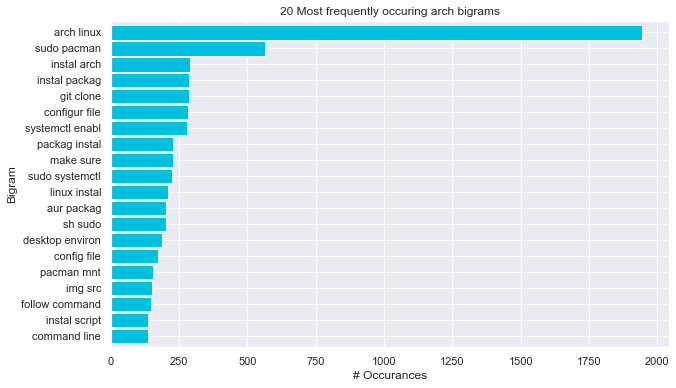

In [57]:
top_20_arch_bigrams.sort_values().plot.barh(color='#00C0DE', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring arch bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_arch_bigrams.reset_index().sort_index(ascending=False)['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

### Debian

### Ubuntu

# Finding our answers:

Through the Exploration phase, we found some answers to some of our questions.
Such as, 

- 1) How many & what are the unique words to each specific programming language?<br>
<b>ANSWER: 

- 2) Are there any bigrams/trigrams that are specific to certain programming languages?<br>
<b>ANSWER:


- 3) Are there differences in words/phrases to Linux-flavors- specifically Ubuntu, Debian and Archlinux?<br>
<b>ANSWER:
<br>
<br>
Though we can prove these answers through our observations through Exploration, to have more validity to find if some of our hypothesis were correct, we needed to have further exploration through hypothesis testing.


# Hypothesis Testing

## Hypothesis 1
$H_{0}$ = Ubuntu distribution repos' readme files contain less than or equal text when comparing it to readme files for other distributions.<br><br>
$H_{a}$ = Ubuntu distribution repos' readme files contain more text than readme files for other distributions.

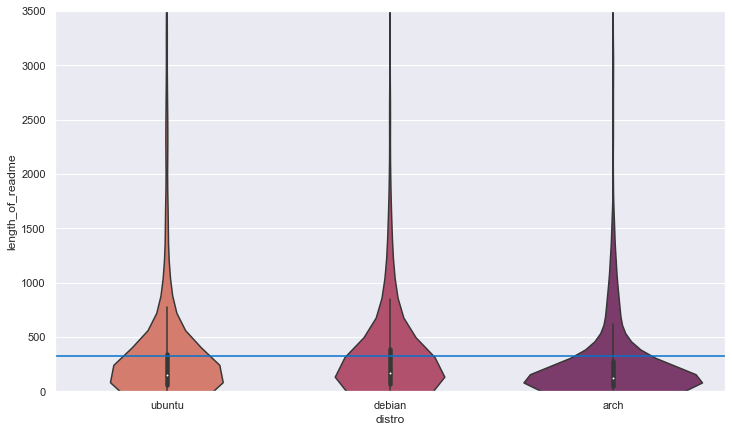

In [58]:
# Visualizing the shape and stat of the data from Hypothesis number 1 to be tested.
plt.figure(figsize=(12,7))
sns.violinplot(data = master_df, y = 'length_of_readme', x = 'distro', palette = 'flare')
plt.axhline(master_df.length_of_readme.mean(), color = '#0372CB')
plt.ylim(0, 3500)
plt.show()


In [59]:
# Setting alpha
alpha = .05

# Setting variables
ubuntu = master_df[master_df.distro == 'ubuntu']
debian = master_df[master_df.distro == 'debian']
arch = master_df[master_df.distro == 'arch']
non_ubuntu = master_df[master_df.distro != 'ubuntu']

In [64]:
# Checking for variance with levene
stats.levene(ubuntu.length_of_readme, non_ubuntu.length_of_readme)
# Variance can be set to true

LeveneResult(statistic=2.5541003347062237, pvalue=0.11012113267346564)

In [66]:
# Performing t-test and printing out if the result is statistically significant and what the t value is.
t, p = stats.ttest_ind(ubuntu.length_of_readme, non_ubuntu.length_of_readme, equal_var=True)

(p/2) < alpha, t

(True, 1.659202190527968)

### Results:
<div class="alert alert-info">
Because p/2 is less than alpha and the t value is positive, I can reject the null hypothesis. Ubuntu distribution repos' readme files contain more text than readme files for other distributions.
</div>

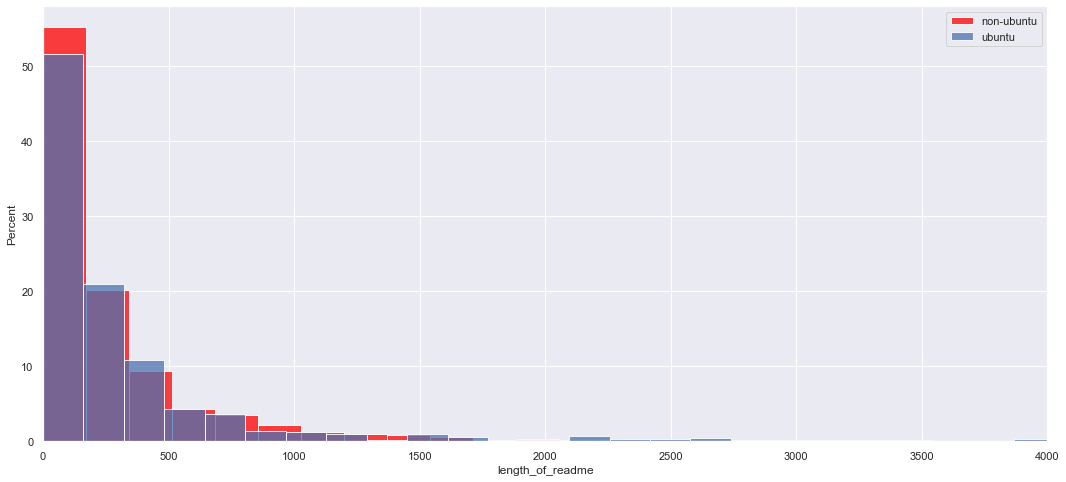

In [68]:
#Visualization of these results
plt.figure(figsize=(18,8))
sns.histplot(data = non_ubuntu.length_of_readme, bins = 100, color = 'red', label = 'non-ubuntu', stat = 'percent')
sns.histplot(data = ubuntu.length_of_readme, bins = 93, label = 'ubuntu', stat = 'percent')
plt.xlim(0, 4000)
plt.legend()
plt.show()

_____________________

## Hypothesis 2
$H_{0}$ =  Programming language is independent of linux distribution type.<br><br>
$H_{a}$ = Programming language is dependent of linux distribution type.

In [69]:
# Setting corpus variables
arch_language_nums = [len(arch.query("language == 'Shell'")), 
                      len(arch.query("language == 'Python'")), 
                      len(arch.query("language == 'C'")),
                      len(arch.query("language !='Shell' & language != 'Python' & language != 'C'"))]

debian_language_nums = [len(debian.query("language == 'Shell'")), 
                      len(debian.query("language == 'Python'")), 
                      len(debian.query("language == 'C'")),
                      len(debian.query("language !='Shell' & language != 'Python' & language != 'C'"))]

ubuntu_language_nums = [len(ubuntu.query("language == 'Shell'")), 
                      len(ubuntu.query("language == 'Python'")), 
                      len(ubuntu.query("language == 'C'")),
                      len(ubuntu.query("language !='Shell' & language != 'Python' & language != 'C'"))]
observed = pd.DataFrame([arch_language_nums, debian_language_nums, ubuntu_language_nums], 
                        columns = ['Shell', 'Python', "C", "Other Langauges"], 
                        index = ['Arch', 'Debian', 'Ubuntu'])
observed

,Shell,Python,C,Other Langauges
Arch,603,89,23,201
Debian,507,96,77,265
Ubuntu,488,104,41,311


In [70]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

p


2.606671303060315e-13

In [71]:
p < alpha

True

### RESULTS:
<div class="alert alert-info">
We reject the null hypothesis. There is a statistically significant relationship between programming language and linux distribution.
</div>

#### Visualization of these relationships:

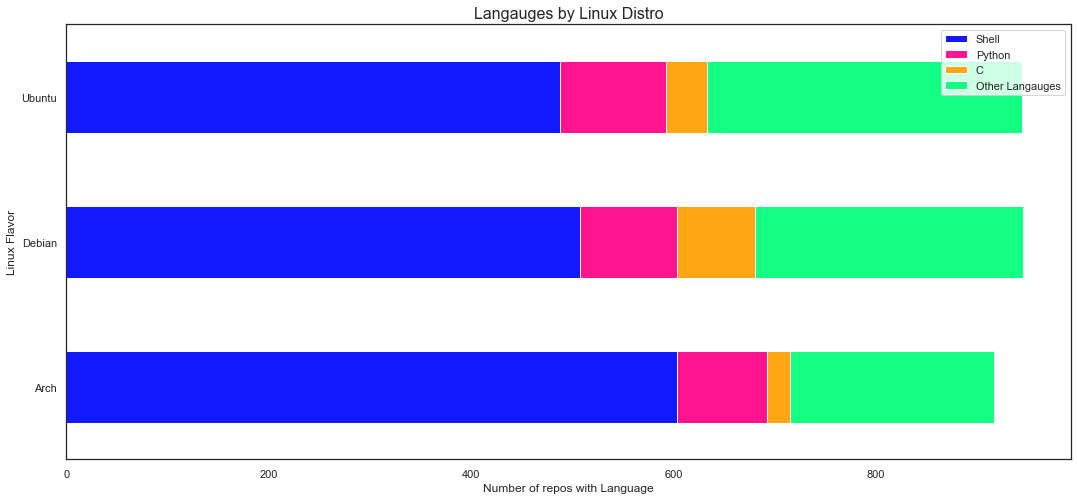

In [72]:
sns.set(style='white')
observed.plot(kind= 'barh', stacked=True, color=['#1319FF', '#FF138F', '#FFA613', '#13FF83'], figsize = (18,8))
plt.legend()
plt.title('Langauges by Linux Distro', fontsize=16)
plt.xlabel('Number of repos with Language')
plt.ylabel('Linux Flavor')
plt.show()


________________________________________

# Modeling Phase:

By exploring what would be the right model, Stephen FitzSimon created a Data Eater (MMM = Mass Model Maker) to run our
dataset through.

This MMM trains and validates our dataset through :<br>
- one Logistic Regression model<br>
- multiple Decision Tree Classifiers <br>
- multiple KNNeighbors <br>
- multiple Random Forest models

#### BASELINE:
Our baseline is the mode at which our top frequency language (Shell) is occuring in the dataset.<br>
<b>BASELINE ACCURACY = 0.52

In [74]:
#reading in the master_df
df_master = pd.read_csv('master_list.csv')

#splitting df through train, validate, and test
train, validate, train = m.make_model_dfs(df_master)

#fitting the train and validate onto data
models_df = m.model_maker(train, validate)

starting rf and et
finished rf and et


In [75]:
models_df.sort_values(['better_than_baseline', 'validate_accuracy'], ascending = False).head(25)

,model,attributes,train_accuracy,validate_accuracy,better_than_baseline
0,LogisticRegression,None,0.673443,0.557814,True
10,Decision Tree Classifier,max_depth = 5,0.642948,0.537484,True
8,Decision Tree Classifier,max_depth = 4,0.599746,0.534519,True
41,KNNeighbors,n_neighbors = 21,0.560356,0.533249,True
35,KNNeighbors,n_neighbors = 18,0.567980,0.532825,True
29,KNNeighbors,n_neighbors = 15,0.571792,0.532402,True
43,KNNeighbors,n_neighbors = 22,0.556544,0.531554,True
31,KNNeighbors,n_neighbors = 16,0.571792,0.531131,True
39,KNNeighbors,n_neighbors = 20,0.560356,0.531131,True
12,Decision Tree Classifier,max_depth = 6,0.665820,0.530284,True


## Takeaways:

_________________________________

# Chosen Model:

_____________________________

# Testing Model Results:

________________________________

# Next Steps: